In [ ]:
%run ./utils.ipynb

In [ ]:
ds_means, ds_std = map(np.array, ([0.3, 0.3, 0.3], [0.33, 0.33, 0.33]))

In [ ]:
STACKING_DN_TRAIN = Path('../data/train_stacking/')
STACKING_DN_TEST = Path('../data/test_stacking/')

In [5]:
# %%time

# sz = 202
# max_crop_sz = int(sz * 0.9)

# trn_tfms = albumentations.Compose([
#     albumentations.HorizontalFlip(),
#     albumentations.RandomSizedCrop((max_crop_sz, max_crop_sz), sz, sz, interpolation=1, p=0.5),
#     albumentations.IAAAffine(rotate=10, p=0.5, mode='edge'),
#     albumentations.Blur()
# ])

# fold = 0
# db = get_data_bunch(sz=202, bs=16, part=fold, trn_tfms=trn_tfms)

# names = ['incv4_tuned_10', 'se_res50', 'unet34_like_full_size']

# val_paths = []
# for fold in range(n_splits):
#     db = get_data_bunch(sz=202, bs=16, part=fold, trn_tfms=trn_tfms)
#     val_paths += db.valid_dl.dl.dataset.x
    
# test_paths = db.test_dl.dl.dataset.x

# val_fns = [val_path.name for val_path in val_paths]
# test_fns = [test_path.name for test_path in test_paths]

# val_preds_comb = np.zeros((4000, 101, 101, 3))
# for i, name in enumerate(names):
#     preds = np.load(f'/home/radek/db/salt/val_preds_{name}.npy')
#     val_preds_comb[:,:,:,i] = np.stack([skimage.transform.resize(pred, (101, 101), anti_aliasing=False, preserve_range=True, mode='constant') for pred in preds])

# for pred, fn in zip(val_preds_comb, val_fns):
#     im = (pred * 255).astype(np.uint8)
#     im = PIL.Image.fromarray(im)
#     im.save(STACKING_DN_TRAIN/'101'/'images'/fn)

# del val_preds_comb

# test_preds_comb = np.zeros((18000, 101, 101, 3))
# for i, name in enumerate(names):
#     preds = np.load(f'/home/radek/db/salt/test_preds_{name}.npy')
#     test_preds_comb[:,:,:,i] = np.stack([skimage.transform.resize(pred, (101, 101), anti_aliasing=False, preserve_range=True, mode='constant') for pred in preds])

# for pred, fn in zip(test_preds_comb, test_fns):
#     im = (pred * 255).astype(np.uint8)
#     im = PIL.Image.fromarray(im)
#     im.save(STACKING_DN_TEST/'101'/'images'/fn)

# del test_preds_comb

CPU times: user 1min 52s, sys: 26.1 s, total: 2min 18s
Wall time: 2min 58s


In [6]:
# Hyperparameters
folds_to_train = range(n_splits)
name = 'stacker_incv_10'
sz = 101

In [7]:
trn_tfms = albumentations.Compose([
    albumentations.HorizontalFlip(),
])

def get_data_bunch(sz=sz, bs=64, part=0, trn_tfms=trn_tfms):
    trn_ds = FilesDataset(STACKING_DN_TRAIN, sz, take_idxs=trn_parts[part], tfms=trn_tfms)
    val_ds = FilesDataset(STACKING_DN_TRAIN, sz, take_idxs=val_parts[part])
    tst_ds = FilesDataset(STACKING_DN_TEST, sz)
    
    trn_dl = DataLoader(trn_ds, bs, True, num_workers=11, pin_memory=True)
    val_dl = DataLoader(val_ds, bs, False, num_workers=11, pin_memory=True)
    tst_dl = DataLoader(tst_ds, bs, False, num_workers=11, pin_memory=True)
    
    trn_dl, val_dl, tst_dl = map(lambda ts: DeviceDataLoader(*ts), zip([trn_dl, val_dl, tst_dl], [default_device] * 3) )
    return DataBunch(trn_dl, val_dl, tst_dl, default_device)

In [13]:
db = get_data_bunch(sz=sz, bs=40, part=0, trn_tfms=trn_tfms)

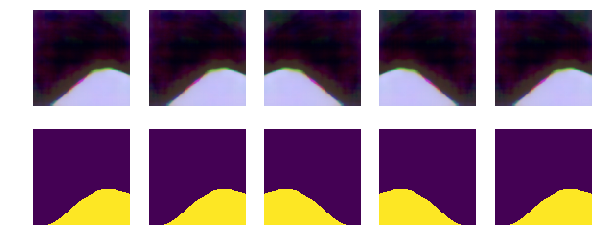

In [14]:
db.train_dl.dl.dataset.check_tfms(1)

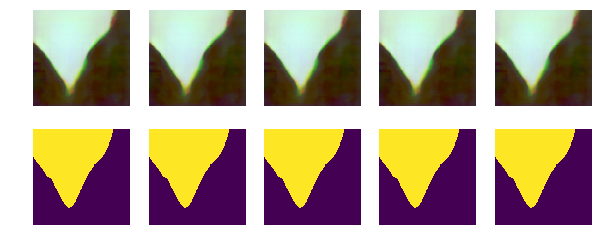

In [15]:
db.valid_dl.dl.dataset.check_tfms(106)

In [8]:
def get_learner(db):
    m = Stacker()
    m.cuda(default_device)
#     learn = Learner(db, m, true_wd=True, loss_fn=bce_loss, opt_fn=lambda x: optim.SGD(x))
    learn = Learner(db, m, true_wd=True, loss_fn=bce_loss, opt_fn=AdamW)
    learn.metrics = [accuracy_thresh, dice, iou_pytorch]
    learn.callbacks = [SaveBest()]
    return learn

In [9]:
class Stacker(nn.Module):
    def forward(self,x):
        return x.mean(1)

In [20]:
# %%time
# for fold in folds_to_train:
#     print(f'### Starting to train fold {fold} ###')
#     db = get_data_bunch(bs=40, part=fold, trn_tfms=trn_tfms)
#     learn = get_learner(db)
#     learn.loss_fn = lovasz_loss
#     learn.callbacks = [ReduceLROnPlateau(learn, patience=8, div_factor=2), StopTrain(learn, patience=20)]
#     learn.fit(200,  5e-2)
#     break
# #     learn.fit(5, 1e-1)
#     learn.save(f'{name}_fold{fold}')

In [ ]:
%%time

for fold in folds_to_train:
    db = get_data_bunch(sz=sz, bs=16, part=fold, trn_tfms=trn_tfms)
    learn = get_learner(db)
    
    learn.load(f'{name}_fold{fold}')
    val_preds, val_targs = predict_with_targs_and_TTA(learn.model, db.valid_dl)
    test_preds = predict_with_TTA(learn.model, db.test_dl)

    val_preds, test_preds = normalize_t(val_preds, val_targs, test_preds)
    print(f'Fold {fold} val acc: {accuracy_np(val_preds, val_targs)}, iou: {iou_metric(val_targs, val_preds > 0.5)}')
    
    np.save(f'/home/radek/db/salt/val_preds_{name}_fold{fold}', val_preds)
    np.save(f'/home/radek/db/salt/val_targs_{name}_fold{fold}', val_targs)
    np.save(f'/home/radek/db/salt/test_preds_{name}_fold{fold}', test_preds)
    del val_preds, val_targs, test_preds

    del learn

In [32]:
%%time

for fold in folds_to_train:
    db = get_data_bunch(sz=sz, bs=16, part=fold, trn_tfms=trn_tfms)
    learn = get_learner(db)
    
    learn.load(f'{name}_fold{fold}')
    val_preds, val_targs = predict_with_targs_and_TTA(learn.model, db.valid_dl)
    test_preds = predict_with_TTA(learn.model, db.test_dl)

    val_preds, test_preds = normalize_t(val_preds, val_targs, test_preds)
    print(f'Fold {fold} val acc: {accuracy_np(val_preds, val_targs)}, iou: {iou_metric(val_targs, val_preds > 0.5)}')
    
    np.save(f'/home/radek/db/salt/val_preds_{name}_fold{fold}', val_preds)
    np.save(f'/home/radek/db/salt/val_targs_{name}_fold{fold}', val_targs)
    np.save(f'/home/radek/db/salt/test_preds_{name}_fold{fold}', test_preds)
    del val_preds, val_targs, test_preds

    del learn

Fold 0 val acc: 0.9576870430028793, iou: 0.8592909535452322
Fold 1 val acc: 0.9651656034690378, iou: 0.8539506172839507
Fold 2 val acc: 0.9713073750282636, iou: 0.8433417085427135
Fold 3 val acc: 0.9697056298612801, iou: 0.8544879898862201
Fold 4 val acc: 0.9686351469226508, iou: 0.8670063694267516
CPU times: user 50.4 s, sys: 57.7 s, total: 1min 48s
Wall time: 2min 55s


In [33]:
%%time
ys = []
preds = []
test_preds = np.zeros((18000, 101, 101))
for fold in folds_to_train:
    y = np.load(f'/home/radek/db/salt/val_targs_{name}_fold{fold}.npy')
    val_preds = np.load(f'/home/radek/db/salt/val_preds_{name}_fold{fold}.npy')
    preds.append(val_preds)
    ys.append(y)
    test_pred = np.load(f'/home/radek/db/salt/test_preds_{name}_fold{fold}.npy')
    test_preds += test_pred / len(folds_to_train)

np.save(f'/home/radek/db/salt/val_preds_{name}.npy', np.concatenate(preds))
np.save(f'/home/radek/db/salt/val_targs_{name}.npy', np.concatenate(ys))
np.save(f'/home/radek/db/salt/test_preds_{name}.npy', test_preds)

CPU times: user 3.32 s, sys: 4.07 s, total: 7.39 s
Wall time: 9.59 s


In [34]:
%%time
for fold in folds_to_train:
    val_preds = np.load(f'/home/radek/db/salt/val_preds_{name}_fold{fold}.npy')
    val_targs = np.load(f'/home/radek/db/salt/val_targs_{name}_fold{fold}.npy')
    print(f'Part {fold}: {accuracy_np(val_preds, val_targs)}, {iou_metric(val_targs, val_preds > 0.5)}, {best_preds_t(val_preds, val_targs)}')

Part 0: 0.9576870430028793, 0.8592909535452322, 0.49999999999999994
Part 1: 0.9651656034690378, 0.8539506172839507, 0.49999999999999994
Part 2: 0.9713073750282636, 0.8433417085427135, 0.49999999999999994
Part 3: 0.9697056298612801, 0.8544879898862201, 0.49999999999999994
Part 4: 0.9686351469226508, 0.8670063694267516, 0.49999999999999994
CPU times: user 5.2 s, sys: 40 ms, total: 5.24 s
Wall time: 5.24 s


In [35]:
val_preds = np.load(f'/home/radek/db/salt/val_preds_{name}.npy')
val_targs = np.load(f'/home/radek/db/salt/val_targs_{name}.npy')

In [36]:
iou_metric(val_targs, val_preds > 0.5)

0.8556

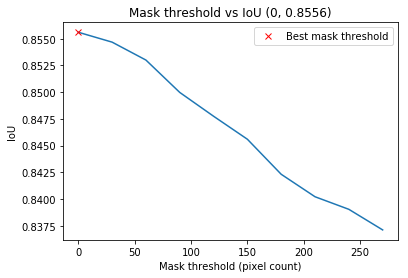

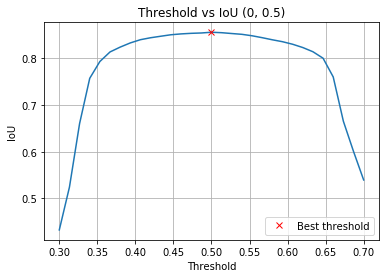

In [14]:
%run diagnostics.ipynb

In [15]:
def preds_to_sub(preds, paths, sig_t, mask_t, name):
    fns = []
    rles = []
    for path, pred in zip(paths, preds):
        pred = pred > sig_t
        pred = filter_image(pred, mask_t)
        fns.append(path.stem)

        rles.append(rle_encode(pred))
    pd.DataFrame(data={'id': fns, 'rle_mask': rles}).to_csv(f'../subs/{name}.csv.gz', compression='gzip', index=False)

In [16]:
test_preds = np.load(f'/home/radek/db/salt/test_preds_{name}.npy')

In [17]:
preds_to_sub(test_preds, db.test_dl.dl.dataset.x, 0.5, 0, name)

In [18]:
!kaggle competitions submit -c tgs-salt-identification-challenge -f ../subs/{name}.csv.gz  -m {name}

Successfully submitted to TGS Salt Identification Challenge